In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.2.0


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
keras = tf.keras
layers = tf.keras.layers

In [5]:
train_image_path=glob.glob('./data/dc/training_set/*/*.jpg')
test_image_path=glob.glob('./data/dc/test_set/*/*.jpg')
len(train_image_path),len(test_image_path)

(8005, 2023)

In [6]:
train_image_label=[int(os.path.basename(p).split('.')[0]=='cat') for p in train_image_path]
test_image_label=[int(os.path.basename(p).split('.')[0]=='cat') for p in test_image_path]

In [7]:
def load_preprocess_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image,label

In [8]:
train_image_ds=tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))
test_image_ds=tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))

In [9]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_image_ds=train_image_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)
test_image_ds=test_image_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)

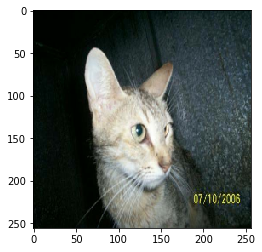

In [10]:
for img, label in train_image_ds.take(1):
    plt.imshow(img)

In [11]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [12]:
BATCH_SIZE=32
train_count = len(train_image_path)
test_count = len(test_image_path)

train_image_ds=train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds=train_image_ds.prefetch(AUTOTUNE).repeat()

test_image_ds=test_image_ds.batch(BATCH_SIZE)
test_image_ds=test_image_ds.prefetch(AUTOTUNE).repeat()

In [13]:
covn_base = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top=False,
                                                 pooling='avg',
                                                 input_shape=(256,256,3))

In [14]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [15]:
model=keras.Sequential()
model.add(covn_base)
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 21,856,553
Non-trainable params: 54,528
_________________________________________________________________


In [17]:
covn_base.trainable=False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
             loss='binary_crossentropy',
             metrics=['acc'])

#  在Xception模型上添加全连层，Xception未训练

In [ ]:
with tf.device('/cpu:0'):
    history=model.fit(
        train_image_ds,
        steps_per_epoch=train_count//BATCH_SIZE,
        epochs=10,
        validation_data=test_image_ds,
        validation_steps=test_count//BATCH_SIZE)

In [ ]:
covn_base.trainable=True

In [ ]:
for layer in covn_base.layers[:len(covn_base.layers)-3]:
    layer.trainable=False

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.00005),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
fine_tune_epoch=5
initial_epoch=8
total_epoch = initial_epoch+fine_tune_epoch

# 训练Xception最后3层网络+全连接层

In [ ]:
with tf.device('/cpu:0'):
    history=model.fit(
        train_image_ds,
        steps_per_epoch=train_count//BATCH_SIZE,
        epochs=total_epoch,
        initial_epoch=initial_epoch,
        validation_data=test_image_ds,
        validation_steps=test_count//BATCH_SIZE)

#  在Xception模型上添加全连层，Xception未训练

In [20]:
with tf.device('/cpu:0'):
    history=model.fit(
        train_image_ds,
        steps_per_epoch=train_count//BATCH_SIZE,
        epochs=10,
        validation_data=test_image_ds,
        validation_steps=test_count//BATCH_SIZE)

Epoch 1/10
250/250 [==============================] - 495s 2s/step - loss: 0.0448 - accuracy: 0.9814 - val_loss: 0.0288 - val_accuracy: 0.9921
Epoch 2/10
250/250 [==============================] - 494s 2s/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0331 - val_accuracy: 0.9931
Epoch 3/10
250/250 [==============================] - 492s 2s/step - loss: 0.0121 - accuracy: 0.9951 - val_loss: 0.0348 - val_accuracy: 0.9926
Epoch 4/10
250/250 [==============================] - 455s 2s/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0369 - val_accuracy: 0.9936
Epoch 5/10
250/250 [==============================] - 444s 2s/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0377 - val_accuracy: 0.9916
Epoch 6/10
250/250 [==============================] - 444s 2s/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0456 - val_accuracy: 0.9911
Epoch 7/10
250/250 [==============================] - 443s 2s/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0479 - val_accuracy: 0.9921

In [21]:
covn_base.trainable=True

In [22]:
for layer in covn_base.layers[:len(covn_base.layers)-3]:
    layer.trainable=False

In [23]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.00005),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [24]:
fine_tune_epoch=5
initial_epoch=8
total_epoch = initial_epoch+fine_tune_epoch

# 训练Xception最后3层网络+全连接层

In [26]:
with tf.device('/cpu:0'):
    history=model.fit(
        train_image_ds,
        steps_per_epoch=train_count//BATCH_SIZE,
        epochs=total_epoch,
        initial_epoch=initial_epoch,
        validation_data=test_image_ds,
        validation_steps=test_count//BATCH_SIZE)

Epoch 9/13
250/250 [==============================] - 447s 2s/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0501 - val_accuracy: 0.9940
Epoch 10/13
250/250 [==============================] - 448s 2s/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0534 - val_accuracy: 0.9931
Epoch 11/13
250/250 [==============================] - 448s 2s/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0507 - val_accuracy: 0.9940
Epoch 12/13
250/250 [==============================] - 445s 2s/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0533 - val_accuracy: 0.9931
Epoch 13/13
250/250 [==============================] - 445s 2s/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0507 - val_accuracy: 0.9940
